In [1]:
!git clone https://github.com/georgiosarvanitidis/geometric_ml.git

Cloning into 'geometric_ml'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 102 (delta 11), reused 40 (delta 8), pack-reused 59
Receiving objects: 100% (102/102), 348.01 KiB | 21.75 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.8 MB/s eta 0:00:00


In [3]:
ls

geometric_ml/  sample_data/


In [4]:
cd geometric_ml/

/content/geometric_ml


In [5]:
import sklearn_extra
from sklearn_extra.cluster import KMedoids

In [9]:
import numpy as np
import torch
import torch.nn as nn
from python.core import utils, generative_models, manifolds, geodesics
import matplotlib.pyplot as plt
import gc
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

import plotly.graph_objects as go

from tqdm import tqdm


In [10]:
params = {'N': 170, 'data_type': 3, 'sigma': 0.1, 'extra_dims': 2, 'r':1}
data, labels = utils.generate_data(params)

In [11]:
data.shape
#utils.my_plot(data)

(170, 5)

In [12]:



z = data[:, 2]
x, y = data[:,0], data[:,1]
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers', marker=dict(
        size=4,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    ))])
fig.show()

In [13]:
d = 2  # The latent space dimension
N_data, D = data.shape
activFunName = 'softplus'  # tanh used in the synthetics
activations_list = {
    'softplus': torch.nn.Softplus(),
    'tanh': torch.nn.Tanh()
}
activFun = activations_list[activFunName]
H = 32
lambda_reg = 1e-8  # For the weights of the networks
epochs = 500
learning_rate = 1e-3  # 0.0001 works for MNIST and 0.1 for the synthetic
clipping_value = 1
batch_size = 128
warmup = int(0.35 * epochs)

# Use PCA to get the linear extrapolation
A_gen, L_gen, b_gen = utils.my_pca(data, d)
A_gen = A_gen @ np.diag(np.sqrt(L_gen))  # Project based on Probabilistic PCA: N(0, 1) -> data

# Construct the VAE
VAE_model = generative_models.VariationalAutoEncoder_GELS(D=D, d=d, H=H, activFun=activFun, A_init=A_gen, b_init=b_gen)
VAE_optimizer = torch.optim.Adam(VAE_model.parameters(), lr=learning_rate)

# Train the VAE
ELBO = np.zeros((epochs, 1))
for epoch in range(epochs):
    # Permute the indices of the train data
    permutation = np.random.permutation(N_data)

    # Initialize the losses
    train_loss = 0
    train_loss_num = 0

    # Train for all the batches
    for i in range(0, N_data, batch_size):
        indices = permutation[i:i + batch_size]
        X_batch = torch.from_numpy(data[indices, :].astype(np.float32)) # batch_indices x D

        # The VAE
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = VAE_model(X_batch)

        # Compute the regularization parameter
        if warmup == 0:
            r = 0
        else:
            r = 1. * epoch / warmup
            if r > 1.:
                r = 1.

        loss = generative_models.VAE_loss_GELS(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                               mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, anneal_param=r)

        # Update the parameters
        VAE_optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        VAE_optimizer.step()

        # Collect the ways
        train_loss += loss.item()
        train_loss_num += 1

    ELBO[epoch] = train_loss / train_loss_num

    if epoch % 20 == 0:
        print("[Epoch: {}/{}] [objective: {:.3f}]".format(epoch, epochs, ELBO[epoch, 0]))

ELBO_train = ELBO[epoch, 0].round(2)  # THe final training ELBO



[Epoch: 0/500] [objective: 2.161]
[Epoch: 20/500] [objective: -3.234]
[Epoch: 40/500] [objective: -3.997]
[Epoch: 60/500] [objective: -4.538]
[Epoch: 80/500] [objective: -4.893]
[Epoch: 100/500] [objective: -4.689]
[Epoch: 120/500] [objective: -5.024]
[Epoch: 140/500] [objective: -4.122]
[Epoch: 160/500] [objective: -3.447]
[Epoch: 180/500] [objective: -2.999]
[Epoch: 200/500] [objective: -2.927]
[Epoch: 220/500] [objective: -2.992]
[Epoch: 240/500] [objective: -3.104]
[Epoch: 260/500] [objective: -2.777]
[Epoch: 280/500] [objective: -3.224]
[Epoch: 300/500] [objective: -2.847]
[Epoch: 320/500] [objective: -2.790]
[Epoch: 340/500] [objective: -3.051]
[Epoch: 360/500] [objective: -3.059]
[Epoch: 380/500] [objective: -3.067]
[Epoch: 400/500] [objective: -3.031]
[Epoch: 420/500] [objective: -3.041]
[Epoch: 440/500] [objective: -2.977]
[Epoch: 460/500] [objective: -3.028]
[Epoch: 480/500] [objective: -3.268]


In [14]:
with torch.no_grad():
    MU_X_data, LOG_VAR_X_data, _, MU_Z_data, LOG_VAR_Z_data = VAE_model(torch.from_numpy(data.astype(np.float32)))
    MU_X_data = MU_X_data.detach().numpy()
    VAR_X_data = LOG_VAR_X_data.exp().detach().numpy()
    MU_Z_data = MU_Z_data.detach().numpy()
    VAR_Z_data = LOG_VAR_Z_data.exp().detach().numpy()


Text(0.5, 1.0, 'Latent space')

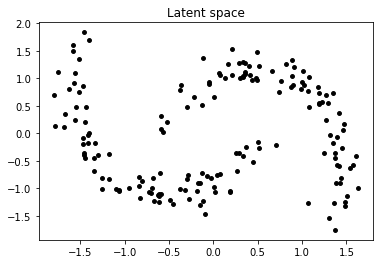

In [15]:
plt.figure()
plt.scatter(MU_Z_data[:, 0], MU_Z_data[:, 1], c='k', s=15)
plt.title('Latent space')

#plt.scatter(data[medioid_indices,0], data[medioid_indices,1], marker = '*', label = 'centroids' , s = 200)

In [16]:
#plt.figure()
#plt.scatter(MU_Z_data1[:, 0], MU_Z_data1[:, 1], c='k', s=15)
#plt.title('Latent space')

In [17]:
# Construct a Riemannian metric from the data
manifold = manifolds.LocalDiagPCA(data=MU_Z_data, sigma=0.15, rho=1e-3)

In [18]:
# Initialize the geodesic solvers
solver_bvp = geodesics.SolverBVP(NMax=100, tol=1e-1)
solver_fp = geodesics.SolverFP(D=2, N=10, tol=1e-1)
N_nodes = 50
solver_graph = geodesics.SolverGraph(manifold, data=KMeans(n_clusters=N_nodes, n_init=50, max_iter=100).fit(MU_Z_data).cluster_centers_,
                                     kNN_num=int(np.log(N_nodes)), tol=1e-2)
solver_comb = geodesics.SolverComb(solver_1=solver_bvp, solver_2=solver_graph)

Kernel type has not been specified (default: Squared Exponential).

[Initialize Graph] [Processed point: 0/50]


In [19]:
utils.my_vector(MU_Z_data[0]).shape


(2, 1)

In [20]:
import sys

In [21]:

def dist (c0,c1):

    
#     curve_comb, logmap_comb, curve_length_comb, failed_comb, solution_comb \
#                 = geodesics.compute_geodesic(solver_comb, manifold, c0, c1)
#     curve_fp, logmap_fp, curve_length_fp, failed_fp, solution_fp \
#                 = geodesics.compute_geodesic(solver_fp, manifold, c0, c1)
#     result = curve_length_fp
    
#     if (failed_fp):
        curve_graph, logmap_graph, curve_length_graph, failed_graph, solution_graph \
                = geodesics.compute_geodesic(solver_graph, manifold, c0, c1)
        
        result = curve_length_graph
        return result

In [22]:

def compute_distances(MU_Z_data):

  distances = np.zeros ((MU_Z_data.shape[0],MU_Z_data.shape[0]))
  for i in tqdm(range(distances.shape[0])):
      c0 = utils.my_vector(MU_Z_data[i])
      print(i)
      for j in range (i+1,distances.shape[0]) :
  #         print(j)
          c1 = utils.my_vector(MU_Z_data [j])
          distances[i,j] = dist (c0,c1)
  return distances

In [23]:
#distances_ = compute_distances(MU_Z_data)

In [25]:
distances = compute_distances(MU_Z_data)

In [ ]:
affinity = distances + distances.T

In [ ]:
affinity.shape

(200, 200)

In [ ]:
def apply_kmedioids (data, metric = 'euclidean',affinity = None ):
    
    if (metric == 'euclidean'):
        kmedio =  KMedoids(n_clusters=2)
        kmedio.fit(data)


# labels 
        label = kmedio.labels_

# plot
        c = ['b','y']
        for l in np.unique(label):
            plt.scatter(data[label == l][:,0], data[label == l][:,1], label = str(l))

        plt.scatter(kmedio.cluster_centers_[:,0], kmedio.cluster_centers_[:,1], marker = '*', label = 'centroids' , s = 200)

        plt.legend()
        
    else : 
        kmedio_rienman =  KMedoids(n_clusters=2,max_iter = 100000, metric = 'precomputed' )
        kmedio_rienman.fit(affinity)


# labels 
        label = kmedio_rienman.labels_

# plot
        c = ['b','y']
        for l in np.unique(label):
            plt.scatter(data[label == l][:,0], data[label == l][:,1], label = str(l))

        medioid_indices = kmedio_rienman.medoid_indices_

        plt.scatter(data[medioid_indices,0], data[medioid_indices,1], marker = '*', label = 'centroids' , s = 200)

        plt.legend()
    return label 
        

/usr/local/lib/python3.8/dist-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Text(0.5, 1.0, 'Riemannian kmediods $\\sigma = $2.2')

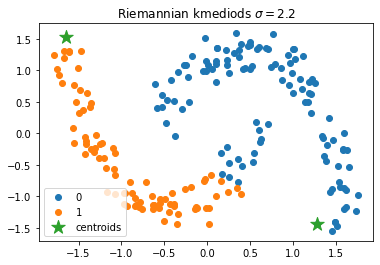

In [ ]:
sigma = 1.9
#plt.figure()
affinity_kernel = np.exp (- affinity / sigma**2)
predicted_labels = apply_kmedioids (MU_Z_data, metric = 'Riemann', affinity = affinity_kernel)
#fscore.append(max (fbeta_score(labels ,predicted_labels,  beta = 1), fbeta_score(labels ,1 - predicted_labels,  beta = 1))) 
#mutual_info.append (mutual_info_score(labels.squeeze() ,predicted_labels))
plt.title (r'Riemannian kmediods $\sigma = ${}'.format (sigma))

Text(0.5, 1.0, 'kmediods Euclidean distance')

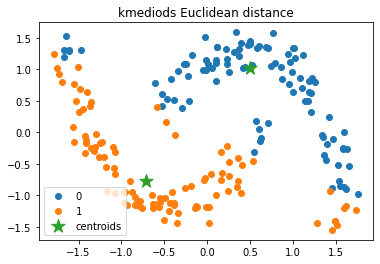

In [ ]:
### kmedioids 

predicted_labels = apply_kmedioids (MU_Z_data, metric = 'euclidean')
plt.title ('kmediods Euclidean distance')

In [26]:
def compare_affinity (range_sigma, affinity):
    plt.figure(figsize =(10,10))
    for i,sigma in enumerate(range_sigma):
        plt.subplot(2,3, i+1)
        affinity_kernel = np.exp (- affinity / sigma**2)
        plt.imshow (affinity_kernel)
        plt.title (r'affinity matrix $\sigma = {}$'.format (sigma))

In [ ]:
compare_affinity([0.1,0.8,1.2,1.8,2.5,10], affinity)